# Introduction to Vector

Vector is a Python 3.8+ library (Python 3.6 and 3.7 supported till `v0.9.0` and `v1.0.0`, respectively) for 2D, 3D, and [Lorentz vectors](https://en.wikipedia.org/wiki/Special_relativity#Physics_in_spacetime), especially _arrays of vectors_, to solve common physics problems in a NumPy-like way.

Main features of Vector:

   * Pure Python with NumPy as its only dependency. This makes it easier to install.
   * Vectors may be represented in a variety of coordinate systems: Cartesian, cylindrical, spherical, and any combination of these with time or proper time for Lorentz vectors. In all, there are 12 coordinate systems: {$x$-$y$ vs $\rho$-$\phi$ in the azimuthal plane} × {$z$ vs $\theta$ vs $\eta$ longitudinally} × {$t$ vs $\tau$ temporally}.
   * Uses names and conventions set by [ROOT](https://root.cern/)'s [TLorentzVector](https://root.cern.ch/doc/master/classTLorentzVector.html) and [Math::LorentzVector](https://root.cern.ch/doc/master/classROOT_1_1Math_1_1LorentzVector.html), as well as [scikit-hep/math](https://github.com/scikit-hep/scikit-hep/tree/master/skhep/math), [uproot-methods TLorentzVector](https://github.com/scikit-hep/uproot3-methods/blob/master/uproot3_methods/classes/TLorentzVector.py), [henryiii/hepvector](https://github.com/henryiii/hepvector), and [coffea.nanoevents.methods.vector](https://coffeateam.github.io/coffea/modules/coffea.nanoevents.methods.vector.html).
   * Implemented on a variety of backends:
      - pure Python objects
      - [SymPy](https://www.sympy.org/en/index.html) vectors
      - NumPy arrays of vectors (as a [structured array](https://numpy.org/doc/stable/user/basics.rec.html) subclass)
      - [Awkward Arrays](https://awkward-array.org/) of vectors
      - potential for more: CuPy, TensorFlow, Torch...
   * Awkward backend also implemented in [Numba](https://numba.pydata.org/) for JIT-compiled calculations on vectors.
   * [JAX](https://awkward-array.org/doc/main/user-guide/how-to-specialize-differentiate-jax.html) and [Dask](https://dask-awkward.readthedocs.io/en/stable/) support through Awkward Arrays.
   * Distinction between geometrical vectors, which have a minimum of attribute and method names, and vectors representing momentum, which have synonyms like `pt` = `rho`, `energy` = `t`, `mass` = `tau`.

This notebook requires Vector, NumPy, Awkward Array, SymPy, and Numba to run.

In [1]:
import numbers

import awkward as ak  # at least version 1.2.0rc5
import numba as nb
import numpy as np
import sympy

import vector

## Constructing a vector or an array of vectors

The easiest way to create one or many vectors is with a helper function:

   * `vector.obj` to make a pure Python vector object,
   * `vector.arr` to make a NumPy array of vectors (lowercase, like `np.array`),
   * `vector.awk` to make an Awkward Array of vectors (uppercase, like `ak.Array`).
   * `vector.zip` to make an Awkward Array of vectors (similar to `ak.zip`)

### Pure Python vectors

You can directly use the `VectorObject` classes to construct object type vectors:

In [2]:
vector.VectorObject2D(x=1.1, y=2.2)

VectorObject2D(x=1.1, y=2.2)

In [3]:
vector.MomentumObject3D(px=1.1, py=2.2, pz=3.3)

MomentumObject3D(px=1.1, py=2.2, pz=3.3)

In [4]:
vector.VectorObject4D(x=1.1, y=2.2, eta=3.3, tau=4.4)

VectorObject4D(x=1.1, y=2.2, eta=3.3, tau=4.4)

and so on for every class.

Or, you can use a single wrapper function to construct all possible combinations of
object type vectors:

In [5]:
vector.obj(x=3, y=4)  # Cartesian 2D vector

VectorObject2D(x=3, y=4)

In [6]:
vector.obj(rho=5, phi=0.9273)  # same in polar coordinates

VectorObject2D(rho=5, phi=0.9273)

In [7]:
vector.obj(x=3, y=4).isclose(
    vector.obj(rho=5, phi=0.9273)
)  # use "isclose" unless they are exactly equal

True

In [8]:
vector.obj(x=3, y=4, z=-2)  # Cartesian 3D vector

VectorObject3D(x=3, y=4, z=-2)

In [9]:
vector.obj(x=3, y=4, z=-2, t=10)  # Cartesian 4D vector

VectorObject4D(x=3, y=4, z=-2, t=10)

In [10]:
vector.obj(
    rho=5, phi=0.9273, eta=-0.39, t=10
)  # in rho-phi-eta-t cylindrical coordinates

VectorObject4D(rho=5, phi=0.9273, eta=-0.39, t=10)

In [11]:
vector.obj(
    pt=5, phi=0.9273, eta=-0.39, E=10
)  # use momentum-synonyms to get a momentum vector

MomentumObject4D(pt=5, phi=0.9273, eta=-0.39, E=10)

In [12]:
vector.obj(rho=5, phi=0.9273, eta=-0.39, t=10) == vector.obj(
    pt=5, phi=0.9273, eta=-0.390035, E=10
)

False

In [13]:
vector.obj(
    rho=5, phi=0.9273, eta=-0.39, t=10
).tau  # geometrical vectors have to use geometrical names ("tau", not "mass")

8.426194916448265

In [14]:
vector.obj(
    pt=5, phi=0.9273, eta=-0.39, E=10
).mass  # momentum vectors can use momentum names (as well as geometrical ones)

8.426194916448265

In [15]:
vector.obj(
    pt=5, phi=0.9273, theta=1.9513, mass=8.4262
)  # any combination of azimuthal, longitudinal, and temporal coordinates is allowed

MomentumObject4D(pt=5, phi=0.9273, theta=1.9513, mass=8.4262)

In [16]:
vector.obj(x=3, y=4, z=-2, t=10).isclose(
    vector.obj(pt=5, phi=0.9273, theta=1.9513, mass=8.4262)
)

True

In [17]:
# Test instance type for any level of granularity.
(
    isinstance(
        vector.obj(x=1.1, y=2.2), vector.Vector
    ),  # is a vector or array of vectors
    isinstance(vector.obj(x=1.1, y=2.2), vector.Vector2D),  # is 2D (not 3D or 4D)
    isinstance(
        vector.obj(x=1.1, y=2.2), vector.VectorObject
    ),  # is a vector object (not an array)
    isinstance(vector.obj(px=1.1, py=2.2), vector.Momentum),  # has momentum synonyms
    isinstance(
        vector.obj(x=1.1, y=2.2, z=3.3, t=4.4), vector.Planar
    ),  # has transverse plane (2D, 3D, or 4D)
    isinstance(
        vector.obj(x=1.1, y=2.2, z=3.3, t=4.4), vector.Spatial
    ),  # has all spatial coordinates (3D or 4D)
    isinstance(
        vector.obj(x=1.1, y=2.2, z=3.3, t=4.4), vector.Lorentz
    ),  # has temporal coordinates (4D)
    isinstance(
        vector.obj(x=1.1, y=2.2, z=3.3, t=4.4).azimuthal, vector.AzimuthalXY
    ),  # azimuthal coordinate type
    isinstance(
        vector.obj(x=1.1, y=2.2, z=3.3, t=4.4).longitudinal, vector.LongitudinalZ
    ),  # longitudinal coordinate type
    isinstance(
        vector.obj(x=1.1, y=2.2, z=3.3, t=4.4).temporal, vector.TemporalT
    ),  # temporal coordinate type
)

(True, True, True, True, True, True, True, True, True, True)

The allowed keyword arguments for 2D vectors are:

   * `x` and `y` for Cartesian azimuthal coordinates,
   * `px` and `py` for momentum,
   * `rho` and `phi` for polar azimuthal coordinates,
   * `pt` and `phi` for momentum.

For 3D vectors, you need the above and:

   * `z` for the Cartesian longitudinal coordinate,
   * `pz` for momentum,
   * `theta` for the spherical polar angle (from $0$ to $\pi$, inclusive),
   * `eta` for pseudorapidity, which is a kind of spherical polar angle.

For 4D vectors, you need the above and:

   * `t` for the Cartesian temporal coordinate,
   * `E` or `energy` to get four-momentum,
   * `tau` for the "proper time" (temporal coordinate in the vector's rest coordinate system),
   * `M` or `mass` to get four-momentum.

Since momentum vectors have momentum-synonyms _in addition_ to the geometrical names, any momentum-synonym will make the whole vector a momentum vector.

If you want to bypass the dimension and coordinate system inference through keyword arguments (e.g. for static typing), you can use specialized constructors:

In [18]:
vector.VectorObject2D.from_xy(1.1, 2.2)

VectorObject2D(x=1.1, y=2.2)

In [19]:
vector.MomentumObject3D.from_rhophiz(1.1, 2.2, 3.3)

MomentumObject3D(pt=1.1, phi=2.2, pz=3.3)

In [20]:
vector.VectorObject4D.from_xyetatau(1.1, 2.2, 3.3, 4.4)

VectorObject4D(x=1.1, y=2.2, eta=3.3, tau=4.4)

and so on, for all combinations of azimuthal, longitudinal, and temporal coordinates, geometric and momentum-flavored.

### SymPy vectors

> **Note:** Operations on SymPy vectors are only 100% compatible with numeric vectors (Python, NumPy, and Awkward backends) if the vectors are positive time-like, that is, if `t**2 > x**2 + y**2 + z**2`. The space-like and negative time-like cases have different sign conventions.

You can directly use the `VectorSympy` and `MomentumSympy` classes to construct object type vectors:

In [21]:
x, y, z, t, px, py, pz, eta, tau = sympy.symbols(
    "x y z t px py pz eta tau",
    real=True,  # see sympy assumptions to add more restrictions on the symbols
)

In [22]:
vector.VectorSympy2D(x=x, y=y)

VectorSympy2D(x=x, y=y)

In [23]:
vector.MomentumSympy3D(px=px, py=py, pz=pz)

MomentumSympy3D(px=px, py=py, pz=pz)

In [24]:
vector.VectorSympy4D(x=x, y=y, eta=eta, tau=tau)

VectorSympy4D(x=x, y=y, eta=eta, tau=tau)

and so on for every class.

In [25]:
# Test instance type for any level of granularity.
(
    # is a vector or array of vectors
    isinstance(vector.VectorSympy2D(x=x, y=y), vector.Vector),
    # is 2D (not 3D or 4D)
    isinstance(vector.VectorSympy2D(x=x, y=y), vector.Vector2D),
    # is a sympy vector (not an array)
    isinstance(vector.VectorSympy2D(x=x, y=y), vector.VectorSympy),
    # has momentum synonyms
    isinstance(vector.MomentumSympy2D(px=px, py=py), vector.Momentum),
    # has transverse plane (2D, 3D, or 4D)
    isinstance(vector.VectorSympy4D(x=x, y=y, z=z, t=t), vector.Planar),
    # has all spatial coordinates (3D or 4D)
    isinstance(vector.VectorSympy4D(x=x, y=y, z=z, t=t), vector.Spatial),
    # has temporal coordinates (4D)
    isinstance(vector.VectorSympy4D(x=x, y=y, z=z, t=t), vector.Lorentz),
    # azimuthal coordinate type
    isinstance(vector.VectorSympy4D(x=x, y=y, z=z, t=t).azimuthal, vector.AzimuthalXY),
    # longitudinal coordinate type
    isinstance(
        vector.VectorSympy4D(x=x, y=y, z=z, t=t).longitudinal, vector.LongitudinalZ
    ),
    # temporal coordinate type
    isinstance(vector.VectorSympy4D(x=x, y=y, z=z, t=t).temporal, vector.TemporalT),
)

(True, True, True, True, True, True, True, True, True, True)

Since `VectorSympy2D`, `VectorSympy3D`, `VectorSympy4D`, and their momentum equivalents operate on SymPy expressions, all of the normal SymPy methods and functions work on the results, coordinates, and the vectors.

In [26]:
sympy.init_session()  # latex printing

IPython console for SymPy 1.12 (Python 3.11.5-64-bit) (ground types: python)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.12/



In [27]:
v1 = vector.VectorSympy2D(x=x, y=y)
sympy.Eq(v1.rho, sympy.sqrt(x**2 + y**2))

In [28]:
v2 = vector.VectorSympy4D(x=x, y=y, z=z, t=t)

In [29]:
v2.to_rhophithetatau().tau

In [30]:
values = {x: 3, y: 2, z: 1, t: 10}  # t**2 > x**2 + y**2 + z**2

In [31]:
v2.is_timelike()

In [32]:
v2.is_timelike().subs(values)

In [33]:
v2.to_rhophithetatau().tau.subs(values).evalf()

In [34]:
v2.boost(v2.to_beta3())

VectorSympy4D(x=x*(1 + x**2/(t**2*(1 + 1/sqrt(1 - x**2/t**2 - y**2/t**2 - z**2/t**2))*(1 - x**2/t**2 - y**2/t**2 - z**2/t**2))) + x/sqrt(1 - x**2/t**2 - y**2/t**2 - z**2/t**2) + x*y**2/(t**2*(1 + 1/sqrt(1 - x**2/t**2 - y**2/t**2 - z**2/t**2))*(1 - x**2/t**2 - y**2/t**2 - z**2/t**2)) + x*z**2/(t**2*(1 + 1/sqrt(1 - x**2/t**2 - y**2/t**2 - z**2/t**2))*(1 - x**2/t**2 - y**2/t**2 - z**2/t**2)), y=y*(1 + y**2/(t**2*(1 + 1/sqrt(1 - x**2/t**2 - y**2/t**2 - z**2/t**2))*(1 - x**2/t**2 - y**2/t**2 - z**2/t**2))) + y/sqrt(1 - x**2/t**2 - y**2/t**2 - z**2/t**2) + x**2*y/(t**2*(1 + 1/sqrt(1 - x**2/t**2 - y**2/t**2 - z**2/t**2))*(1 - x**2/t**2 - y**2/t**2 - z**2/t**2)) + y*z**2/(t**2*(1 + 1/sqrt(1 - x**2/t**2 - y**2/t**2 - z**2/t**2))*(1 - x**2/t**2 - y**2/t**2 - z**2/t**2)), z=z*(1 + z**2/(t**2*(1 + 1/sqrt(1 - x**2/t**2 - y**2/t**2 - z**2/t**2))*(1 - x**2/t**2 - y**2/t**2 - z**2/t**2))) + z/sqrt(1 - x**2/t**2 - y**2/t**2 - z**2/t**2) + x**2*z/(t**2*(1 + 1/sqrt(1 - x**2/t**2 - y**2/t**2 - z**2/t**2))

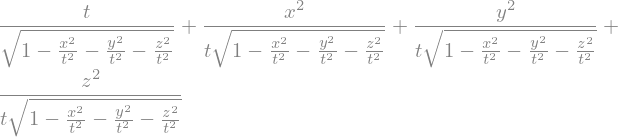

In [35]:
v2.boost(v2.to_beta3()).t

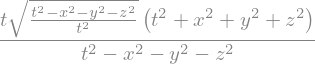

In [36]:
v2.boost(v2.to_beta3()).t.simplify()

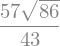

In [37]:
v2.boost(v2.to_beta3()).t.subs(values)

In [38]:
v2.boost(v2.to_beta3()).t.subs(values).evalf()

All of the keyword arguments and rules that apply to `vector.obj` construction apply to `vector.VectorSympyND` and `vector.MomentumObjectND` objects.

### NumPy arrays of vectors

You can directly use the `VectorNumpy` classes to construct object type vectors:

In [39]:
# NumPy-like arguments (literally passed through to NumPy)
vector.VectorNumpy2D(
    [(1.1, 2.1), (1.2, 2.2), (1.3, 2.3), (1.4, 2.4), (1.5, 2.5)],
    dtype=[("x", float), ("y", float)],
)

VectorNumpy2D([(1.1, 2.1), (1.2, 2.2), (1.3, 2.3), (1.4, 2.4), (1.5, 2.5)],
              dtype=[('x', '<f8'), ('y', '<f8')])

In [40]:
# Pandas-like arguments (dict from names to column arrays)
vector.VectorNumpy2D({"x": [1.1, 1.2, 1.3, 1.4, 1.5], "y": [2.1, 2.2, 2.3, 2.4, 2.5]})

VectorNumpy2D([(1.1, 2.1), (1.2, 2.2), (1.3, 2.3), (1.4, 2.4), (1.5, 2.5)],
              dtype=[('x', '<f8'), ('y', '<f8')])

In [41]:
# As with objects, the coordinate system and dimension is taken from the names of the fields.
vector.VectorNumpy4D(
    {
        "x": [1.1, 1.2, 1.3, 1.4, 1.5],
        "y": [2.1, 2.2, 2.3, 2.4, 2.5],
        "z": [3.1, 3.2, 3.3, 3.4, 3.5],
        "t": [4.1, 4.2, 4.3, 4.4, 4.5],
    }
)

VectorNumpy4D([(1.1, 2.1, 3.1, 4.1), (1.2, 2.2, 3.2, 4.2), (1.3, 2.3, 3.3, 4.3),
               (1.4, 2.4, 3.4, 4.4), (1.5, 2.5, 3.5, 4.5)],
              dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('t', '<f8')])

and so on for every class.

Or, you can use a single wrapper function to construct all possible combinations of
NumPy type vectors:

In [42]:
# NumPy-like arguments (literally passed through to NumPy)
vector.array(
    [(1.1, 2.1), (1.2, 2.2), (1.3, 2.3), (1.4, 2.4), (1.5, 2.5)],
    dtype=[("x", float), ("y", float)],
)

VectorNumpy2D([(1.1, 2.1), (1.2, 2.2), (1.3, 2.3), (1.4, 2.4), (1.5, 2.5)],
              dtype=[('x', '<f8'), ('y', '<f8')])

In [43]:
# Pandas-like arguments (dict from names to column arrays)
vector.array({"x": [1.1, 1.2, 1.3, 1.4, 1.5], "y": [2.1, 2.2, 2.3, 2.4, 2.5]})

VectorNumpy2D([(1.1, 2.1), (1.2, 2.2), (1.3, 2.3), (1.4, 2.4), (1.5, 2.5)],
              dtype=[('x', '<f8'), ('y', '<f8')])

In [44]:
# As with objects, the coordinate system and dimension is taken from the names of the fields.
vector.array(
    {
        "x": [1.1, 1.2, 1.3, 1.4, 1.5],
        "y": [2.1, 2.2, 2.3, 2.4, 2.5],
        "z": [3.1, 3.2, 3.3, 3.4, 3.5],
        "t": [4.1, 4.2, 4.3, 4.4, 4.5],
    }
)

VectorNumpy4D([(1.1, 2.1, 3.1, 4.1), (1.2, 2.2, 3.2, 4.2), (1.3, 2.3, 3.3, 4.3),
               (1.4, 2.4, 3.4, 4.4), (1.5, 2.5, 3.5, 4.5)],
              dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('t', '<f8')])

In [45]:
vector.array(
    {
        "pt": [1.1, 1.2, 1.3, 1.4, 1.5],
        "phi": [2.1, 2.2, 2.3, 2.4, 2.5],
        "eta": [3.1, 3.2, 3.3, 3.4, 3.5],
        "M": [4.1, 4.2, 4.3, 4.4, 4.5],
    }
)

MomentumNumpy4D([(1.1, 2.1, 3.1, 4.1), (1.2, 2.2, 3.2, 4.2), (1.3, 2.3, 3.3, 4.3),
                 (1.4, 2.4, 3.4, 4.4), (1.5, 2.5, 3.5, 4.5)],
                dtype=[('rho', '<f8'), ('phi', '<f8'), ('eta', '<f8'), ('tau', '<f8')])

Existing NumPy arrays can be viewed as arrays of vectors, but it needs to be a [structured array](https://numpy.org/doc/stable/user/basics.rec.html) with recognized field names.

In [46]:
# NumPy array         # interpret groups of four values as named fields              # give it vector properties and methods
np.arange(0, 24, 0.1).view(
    [("x", float), ("y", float), ("z", float), ("t", float)]
).view(vector.VectorNumpy4D)

VectorNumpy4D([( 0. ,  0.1,  0.2,  0.3), ( 0.4,  0.5,  0.6,  0.7),
               ( 0.8,  0.9,  1. ,  1.1), ( 1.2,  1.3,  1.4,  1.5),
               ( 1.6,  1.7,  1.8,  1.9), ( 2. ,  2.1,  2.2,  2.3),
               ( 2.4,  2.5,  2.6,  2.7), ( 2.8,  2.9,  3. ,  3.1),
               ( 3.2,  3.3,  3.4,  3.5), ( 3.6,  3.7,  3.8,  3.9),
               ( 4. ,  4.1,  4.2,  4.3), ( 4.4,  4.5,  4.6,  4.7),
               ( 4.8,  4.9,  5. ,  5.1), ( 5.2,  5.3,  5.4,  5.5),
               ( 5.6,  5.7,  5.8,  5.9), ( 6. ,  6.1,  6.2,  6.3),
               ( 6.4,  6.5,  6.6,  6.7), ( 6.8,  6.9,  7. ,  7.1),
               ( 7.2,  7.3,  7.4,  7.5), ( 7.6,  7.7,  7.8,  7.9),
               ( 8. ,  8.1,  8.2,  8.3), ( 8.4,  8.5,  8.6,  8.7),
               ( 8.8,  8.9,  9. ,  9.1), ( 9.2,  9.3,  9.4,  9.5),
               ( 9.6,  9.7,  9.8,  9.9), (10. , 10.1, 10.2, 10.3),
               (10.4, 10.5, 10.6, 10.7), (10.8, 10.9, 11. , 11.1),
               (11.2, 11.3, 11.4, 11.5), (11.6, 11.7, 11.8, 11

Since `VectorNumpy2D`, `VectorNumpy3D`, `VectorNumpy4D`, and their momentum equivalents are NumPy array subclasses, all of the normal NumPy methods and functions work on them.

In [47]:
np.arange(0, 24, 0.1).view(
    [("x", float), ("y", float), ("z", float), ("t", float)]
).view(vector.VectorNumpy4D).reshape(6, 5, 2)

VectorNumpy4D([[[( 0. ,  0.1,  0.2,  0.3), ( 0.4,  0.5,  0.6,  0.7)],
                [( 0.8,  0.9,  1. ,  1.1), ( 1.2,  1.3,  1.4,  1.5)],
                [( 1.6,  1.7,  1.8,  1.9), ( 2. ,  2.1,  2.2,  2.3)],
                [( 2.4,  2.5,  2.6,  2.7), ( 2.8,  2.9,  3. ,  3.1)],
                [( 3.2,  3.3,  3.4,  3.5), ( 3.6,  3.7,  3.8,  3.9)]],

               [[( 4. ,  4.1,  4.2,  4.3), ( 4.4,  4.5,  4.6,  4.7)],
                [( 4.8,  4.9,  5. ,  5.1), ( 5.2,  5.3,  5.4,  5.5)],
                [( 5.6,  5.7,  5.8,  5.9), ( 6. ,  6.1,  6.2,  6.3)],
                [( 6.4,  6.5,  6.6,  6.7), ( 6.8,  6.9,  7. ,  7.1)],
                [( 7.2,  7.3,  7.4,  7.5), ( 7.6,  7.7,  7.8,  7.9)]],

               [[( 8. ,  8.1,  8.2,  8.3), ( 8.4,  8.5,  8.6,  8.7)],
                [( 8.8,  8.9,  9. ,  9.1), ( 9.2,  9.3,  9.4,  9.5)],
                [( 9.6,  9.7,  9.8,  9.9), (10. , 10.1, 10.2, 10.3)],
                [(10.4, 10.5, 10.6, 10.7), (10.8, 10.9, 11. , 11.1)],
                

All of the keyword arguments and rules that apply to `vector.obj` construction apply to `vector.array` dtypes.

Geometrical names are used in the dtype, even if momentum-synonyms are used in construction.

In [48]:
vector.array(
    {"px": [1, 2, 3, 4], "py": [1.1, 2.2, 3.3, 4.4], "pz": [0.1, 0.2, 0.3, 0.4]}
)

MomentumNumpy3D([(1., 1.1, 0.1), (2., 2.2, 0.2), (3., 3.3, 0.3), (4., 4.4, 0.4)],
                dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8')])

### Awkward Arrays of vectors

[Awkward Arrays](https://awkward-array.org/) are arrays with more complex data structures than NumPy allows, such as variable-length lists, nested records, missing and even heterogeneous data (multiple data types: use sparingly).

The `vector.Array` function behaves exactly like the [ak.Array](https://awkward-array.readthedocs.io/en/latest/_auto/ak.Array.html) constructor, except that it makes arrays of vectors.

In [49]:
vector.Array(
    [
        [{"x": 1, "y": 1.1, "z": 0.1}, {"x": 2, "y": 2.2, "z": 0.2}],
        [],
        [{"x": 3, "y": 3.3, "z": 0.3}],
        [
            {"x": 4, "y": 4.4, "z": 0.4},
            {"x": 5, "y": 5.5, "z": 0.5},
            {"x": 6, "y": 6.6, "z": 0.6},
        ],
    ]
)

<VectorArray3D [[{x: 1, y: 1.1, ...}, {...}], ...] type='4 * var * Vector3D...'>

If you want _any_ records named "`Vector2D`", "`Vector3D`", "`Vector4D`", "`Momentum2D`", "`Momentum3D`", or "`Momentum4D`" to be interpreted as vectors, register the behaviors globally.

In [50]:
vector.register_awkward()

In [51]:
ak.Array(
    [
        [{"x": 1, "y": 1.1, "z": 0.1}, {"x": 2, "y": 2.2, "z": 0.2}],
        [],
        [{"x": 3, "y": 3.3, "z": 0.3}],
        [
            {"x": 4, "y": 4.4, "z": 0.4},
            {"x": 5, "y": 5.5, "z": 0.5},
            {"x": 6, "y": 6.6, "z": 0.6},
        ],
    ],
    with_name="Vector3D",
)

<VectorArray3D [[{x: 1, y: 1.1, ...}, {...}], ...] type='4 * var * Vector3D...'>

All of the keyword arguments and rules that apply to `vector.obj` construction apply to `vector.Array` field names.

Finally, the `VectorAwkward` mixins can be subclassed to create custom vector classes. The awkward behavior classes and projections must be named as `*Array`. For example, `coffea` uses the following names - `TwoVectorArray`, `ThreeVectorArray`, `PolarTwoVectorArray`, `SphericalThreeVectorArray`, ...

## Vector properties

Any geometrical coordinate can be computed from vectors in any coordinate system; they'll be provided or computed as needed.

In [52]:
vector.obj(x=3, y=4).rho

In [53]:
vector.obj(rho=5, phi=0.9273).x

In [54]:
vector.obj(rho=5, phi=0.9273).y

In [55]:
vector.obj(x=1, y=2, z=3).theta

In [56]:
vector.obj(x=1, y=2, z=3).eta

Some properties are not coordinates, but derived from them.

In [57]:
vector.obj(x=1, y=2, z=3).costheta

In [58]:
vector.obj(x=1, y=2, z=3).mag  # spatial magnitude

In [59]:
vector.obj(x=1, y=2, z=3).mag2  # spatial magnitude squared

These properties are provided because they can be computed faster or with more numerical stability in different coordinate systems. For instance, the magnitude ignores `phi` in polar coordinates.

In [60]:
vector.obj(rho=3, phi=0.123456789, z=4).mag2

Momentum vectors have geometrical properties as well as their momentum-synonyms.

In [61]:
vector.obj(px=3, py=4).rho

In [62]:
vector.obj(px=3, py=4).pt

In [63]:
vector.obj(x=1, y=2, z=3, E=4).tau

In [64]:
vector.obj(x=1, y=2, z=3, E=4).mass

Here's the key thing: _arrays of vectors return arrays of coordinates_.

In [65]:
vector.array(
    {
        "x": [1.0, 2.0, 3.0, 4.0, 5.0],
        "y": [1.1, 2.2, 3.3, 4.4, 5.5],
        "z": [0.1, 0.2, 0.3, 0.4, 0.5],
    }
).theta

array([1.50363023, 1.50363023, 1.50363023, 1.50363023, 1.50363023])

In [66]:
vector.Array(
    [
        [{"x": 1, "y": 1.1, "z": 0.1}, {"x": 2, "y": 2.2, "z": 0.2}],
        [],
        [{"x": 3, "y": 3.3, "z": 0.3}],
        [{"x": 4, "y": 4.4, "z": 0.4}, {"x": 5, "y": 5.5, "z": 0.5}],
    ]
).theta

<Array [[1.5, 1.5], [], [1.5], [1.5, 1.5]] type='4 * var * float64'>

In [67]:
# Make a large, random NumPy array of 3D momentum vectors.
array = (
    np.random.normal(0, 1, 150)
    .view([(x, float) for x in ("x", "y", "z")])
    .view(vector.MomentumNumpy3D)
    .reshape(5, 5, 2)
)
array

MomentumNumpy3D([[[(-0.57563366, -1.47699474, -0.47994495),
                   ( 0.89352352, -0.54653254, -1.19265982)],
                  [( 0.65238098, -1.16036404, -0.77114054),
                   ( 0.98179895,  0.83873052,  0.20782947)],
                  [( 0.28760738,  1.94304859,  1.41478171),
                   ( 0.49411618, -1.04273322, -0.71518308)],
                  [(-1.36682398, -0.94597456, -0.73709658),
                   ( 2.03310802, -0.30766412,  1.98470129)],
                  [( 1.49521531, -0.87638969, -0.23913866),
                   (-0.46980167,  0.62148637,  1.99592602)]],

                 [[(-1.05207609, -1.44829405, -1.10489952),
                   ( 0.8946932 , -1.00756739, -0.16826565)],
                  [(-0.02981107, -0.42955782, -0.14474439),
                   (-0.20049079, -2.35649518, -0.05785158)],
                  [(-2.16564064, -0.08356786,  1.13762491),
                   (-0.66967829, -1.38382422,  0.09770476)],
                  [( 1.3710595

In [68]:
# Get the transverse momentum of each one.
array.pt

array([[[1.58520269, 1.04741687],
        [1.33118205, 1.29127769],
        [1.96421889, 1.15388187],
        [1.66225018, 2.0562552 ],
        [1.73312657, 0.77907568]],

       [[1.79008931, 1.34746724],
        [0.43059101, 2.36500869],
        [2.1672524 , 1.53734787],
        [1.37754427, 0.43498751],
        [2.23157218, 0.54726686]],

       [[2.69602923, 0.61157855],
        [1.48145061, 1.12814294],
        [2.32513177, 1.14725375],
        [1.60811495, 0.69656434],
        [1.2950895 , 1.07948576]],

       [[2.16086542, 1.05592472],
        [0.45965451, 1.37970388],
        [1.80060516, 2.95710439],
        [1.64134144, 0.09715532],
        [0.94773578, 2.12141984]],

       [[0.65991813, 1.63785511],
        [0.7437487 , 0.42037916],
        [0.81821336, 0.71935698],
        [0.95310429, 0.51285535],
        [1.13048188, 1.1268879 ]]])

In [69]:
# The array and its components have the same shape.
array.shape

In [70]:
array.pt.shape

In [71]:
# Make a large, random Awkward Array of 3D momentum vectors.
array = vector.Array(
    [
        [
            {x: np.random.normal(0, 1) for x in ("px", "py", "pz")}
            for inner in range(np.random.poisson(1.5))
        ]
        for outer in range(50)
    ]
)
array

<MomentumArray3D [[{x: -0.969, y: 0.833, ...}, ...], ...] type='50 * var * ...'>

In [72]:
# Get the transverse momentum of each one, in the same nested structure.
array.pt

<Array [[1.28, 0.791, 1.69], ..., [1.1, ..., 1.39]] type='50 * var * float64'>

In [73]:
# The array and its components have the same list lengths (and can therefore be used together in subsequent calculations).
ak.num(array)

<Array [3, 2, 1, 1, 1, 2, 2, 1, ..., 1, 1, 1, 3, 2, 0, 0, 3] type='50 * int64'>

In [74]:
ak.num(array.pt)

<Array [3, 2, 1, 1, 1, 2, 2, 1, ..., 1, 1, 1, 3, 2, 0, 0, 3] type='50 * int64'>

## Vector methods

Vector methods require arguments (in parentheses), which may be scalars or other vectors, depending on the calculation.

In [75]:
vector.obj(x=3, y=4).rotateZ(0.1)

VectorObject2D(x=2.585678829246765, y=4.279516911052588)

In [76]:
vector.obj(rho=5, phi=0.4).rotateZ(0.1)

VectorObject2D(rho=5, phi=0.5)

In [77]:
# Broadcasts a scalar rotation angle of 0.5 to all elements of the NumPy array.
print(
    vector.array({"rho": [1, 2, 3, 4, 5], "phi": [0.1, 0.2, 0.3, 0.4, 0.5]}).rotateZ(
        0.5
    )
)

[(1., 0.6) (2., 0.7) (3., 0.8) (4., 0.9) (5., 1. )]


In [78]:
# Matches each rotation angle to an element of the NumPy array.
print(
    vector.array({"rho": [1, 2, 3, 4, 5], "phi": [0.1, 0.2, 0.3, 0.4, 0.5]}).rotateZ(
        np.array([0.1, 0.2, 0.3, 0.4, 0.5])
    )
)

[(1., 0.2) (2., 0.4) (3., 0.6) (4., 0.8) (5., 1. )]


In [79]:
# Broadcasts a scalar rotation angle of 0.5 to all elements of the Awkward Array.
print(
    vector.Array(
        [[{"rho": 1, "phi": 0.1}, {"rho": 2, "phi": 0.2}], [], [{"rho": 3, "phi": 0.3}]]
    ).rotateZ(0.5)
)

[[{rho: 1, phi: 0.6}, {rho: 2, phi: 0.7}], [], [{rho: 3, phi: 0.8}]]


In [80]:
# Broadcasts a rotation angle of 0.1 to both elements of the first list, 0.2 to the empty list, and 0.3 to the only element of the last list.
print(
    vector.Array(
        [[{"rho": 1, "phi": 0.1}, {"rho": 2, "phi": 0.2}], [], [{"rho": 3, "phi": 0.3}]]
    ).rotateZ([0.1, 0.2, 0.3])
)

[[{rho: 1, phi: 0.2}, {rho: 2, phi: 0.3}], [], [{rho: 3, phi: 0.6}]]


In [81]:
# Matches each rotation angle to an element of the Awkward Array.
print(
    vector.Array(
        [[{"rho": 1, "phi": 0.1}, {"rho": 2, "phi": 0.2}], [], [{"rho": 3, "phi": 0.3}]]
    ).rotateZ([[0.1, 0.2], [], [0.3]])
)

[[{rho: 1, phi: 0.2}, {rho: 2, phi: 0.4}], [], [{rho: 3, phi: 0.6}]]


Some methods are equivalent to binary operators.

In [82]:
vector.obj(x=3, y=4).scale(10)

VectorObject2D(x=30, y=40)

In [83]:
vector.obj(x=3, y=4) * 10

VectorObject2D(x=30, y=40)

In [84]:
10 * vector.obj(x=3, y=4)

VectorObject2D(x=30, y=40)

In [85]:
vector.obj(rho=5, phi=0.5) * 10

VectorObject2D(rho=50, phi=0.5)

Some methods involve more than one vector.

In [86]:
vector.obj(x=1, y=2).add(vector.obj(x=5, y=5))

VectorObject2D(x=6, y=7)

In [87]:
vector.obj(x=1, y=2) + vector.obj(x=5, y=5)

VectorObject2D(x=6, y=7)

In [88]:
vector.obj(x=1, y=2).dot(vector.obj(x=5, y=5))

In [89]:
vector.obj(x=1, y=2) @ vector.obj(x=5, y=5)

The vectors can use different coordinate systems. Conversions are necessary, but minimized for speed and numeric stability.

In [90]:
vector.obj(x=3, y=4) @ vector.obj(x=6, y=8)  # both are Cartesian, dot product is exact

In [91]:
vector.obj(rho=5, phi=0.9273) @ vector.obj(
    x=6, y=8
)  # one is polar, dot product is approximate

In [92]:
vector.obj(x=3, y=4) @ vector.obj(
    rho=10, phi=0.9273
)  # one is polar, dot product is approximate

In [93]:
vector.obj(rho=5, phi=0.9273) @ vector.obj(
    rho=10, phi=0.9273
)  # both are polar, a formula that depends on phi differences is used

In Python, some "operators" are actually built-in functions, such as `abs`.

In [94]:
abs(vector.obj(x=3, y=4))

Note that `abs` returns

   * `rho` for 2D vectors
   * `mag` for 3D vectors
   * `tau` (`mass`) for 4D vectors

Use the named properties when you want magnitude in a specific number of dimensions; use `abs` when you want the magnitude for any number of dimensions.

The vectors can be from different backends. Normal rules for broadcasting Python numbers, NumPy arrays, and Awkward Arrays apply.

In [95]:
vector.array({"x": [1, 2, 3, 4, 5], "y": [0.1, 0.2, 0.3, 0.4, 0.5]}) + vector.obj(
    x=10, y=5
)

VectorNumpy2D([(11., 5.1), (12., 5.2), (13., 5.3), (14., 5.4), (15., 5.5)],
              dtype=[('x', '<f8'), ('y', '<f8')])

In [96]:
(
    vector.Array(
        [  # an Awkward Array of vectors
            [{"x": 1, "y": 1.1}, {"x": 2, "y": 2.2}],
            [],
            [{"x": 3, "y": 3.3}],
            [{"x": 4, "y": 4.4}, {"x": 5, "y": 5.5}],
        ]
    )
    + vector.obj(x=10, y=5)  # and a single vector object
)

<VectorArray2D [[{x: 11, y: 6.1}, {...}], ..., [...]] type='4 * var * Vecto...'>

In [97]:
(
    vector.Array(
        [  # an Awkward Array of vectors
            [{"x": 1, "y": 1.1}, {"x": 2, "y": 2.2}],
            [],
            [{"x": 3, "y": 3.3}],
            [{"x": 4, "y": 4.4}, {"x": 5, "y": 5.5}],
        ]
    )
    + vector.array(
        {"x": [4, 3, 2, 1], "y": [0.1, 0.1, 0.1, 0.1]}
    )  # and a NumPy array of vectors
)

<VectorArray2D [[{x: 5, y: 1.2}, {...}], ..., [...]] type='4 * var * Vector...'>

Some operations are defined for 2D or 3D vectors, but are usable on higher-dimensional vectors because the additional components can be ignored or are passed through unaffected.

In [98]:
vector.obj(rho=1, phi=0.5).deltaphi(
    vector.obj(rho=2, phi=0.3)
)  # deltaphi is a planar operation (defined on the transverse plane)

In [99]:
vector.obj(rho=1, phi=0.5, z=10).deltaphi(
    vector.obj(rho=2, phi=0.3, theta=1.4)
)  # but we can use it on 3D vectors

In [100]:
vector.obj(rho=1, phi=0.5, z=10, t=100).deltaphi(
    vector.obj(rho=2, phi=0.3, theta=1.4, tau=1000)
)  # and 4D vectors

In [101]:
vector.obj(rho=1, phi=0.5).deltaphi(
    vector.obj(rho=2, phi=0.3, theta=1.4, tau=1000)
)  # and mixed dimensionality

This is especially useful for giving 4D vectors all the capabilities of 3D vectors.

In [102]:
vector.obj(x=1, y=2, z=3).rotateX(np.pi / 4)

VectorObject3D(x=1, y=-0.7071067811865472, z=3.5355339059327378)

In [103]:
vector.obj(x=1, y=2, z=3, tau=10).rotateX(np.pi / 4)

VectorObject4D(x=1, y=-0.7071067811865472, z=3.5355339059327378, tau=10)

In [104]:
vector.obj(pt=1, phi=1.3, eta=2).deltaR(vector.obj(pt=2, phi=0.3, eta=1))

In [105]:
vector.obj(pt=1, phi=1.3, eta=2, mass=5).deltaR(
    vector.obj(pt=2, phi=0.3, eta=1, mass=10)
)

For a few operations - `+`, `-`, `==`, `!=`, ... - the dimension of the vectors should be equal. This can be achieved by using the `like` method, `to_{coordinate_name}` methods, `to_Vector*D` methods. The `to_Vector*D` methods provide more flexibility to the users, that is, new coordinate values can be passed into the methods as named arguments.

In [106]:
v1 = vector.obj(x=1, y=2, z=3)
v2 = vector.obj(x=1, y=2)

print(v1 - v2.like(v1))           # transforms v2 to v1's coordinate system (imputes z=0)
print(v1.like(v2) - v2)           # transforms v1 to v2's coordinate system (removes z)
print(v1 - v2.to_xyz())           # transforms v2 to xyz coordinates (imputes z=0)
print(v1.to_xy() - v2)            # transforms v1 to xy coordinates (removes z)
print(v1 - v2.to_Vector3D(z=3))   # transforms v2 to 3D (imputes z=3)
print(v1.to_Vector2D() - v2)      # transforms v1 to 2D (removes z)

VectorObject3D(x=0, y=0, z=3.0)
VectorObject2D(x=0, y=0)
VectorObject3D(x=0, y=0, z=3.0)
VectorObject2D(x=0, y=0)
VectorObject3D(x=0, y=0, z=0)
VectorObject2D(x=0, y=0)


Similarly, for a few vector methods, the dimension of the input vectors are type checked strictly.

For instance, a cross-product is only defined for 3D and 7D vectors; hence, running the method on a 4D vector will error out.

In [107]:
vector.obj(x=0.1, y=0.2, z=0.3).cross(vector.obj(x=0.4, y=0.5, z=0.6))

VectorObject3D(x=-0.03, y=0.06, z=-0.030000000000000013)

The (current) list of properties and methods is:

**Planar (2D, 3D, 4D):**

   * `x` (`px`)
   * `y` (`py`)
   * `rho` (`pt`): two-dimensional magnitude
   * `rho2` (`pt2`): two-dimensional magnitude squared
   * `phi`
   * `deltaphi(vector)`: difference in `phi` (signed and rectified to $-\pi$ through $\pi$)
   * `rotateZ(angle)`
   * `transform2D(obj)`: the `obj` must supply components through `obj["xx"]`, `obj["xy"]`, `obj["yx"]`, `obj["yy"]`
   * `is_parallel(vector, tolerance=1e-5)`: only true _if they're pointing in the same direction_
   * `is_antiparallel(vector, tolerance=1e-5)`: only true _if they're pointing in opposite directions_
   * `is_perpendicular(vector, tolerance=1e-5)`

**Spatial (3D, 4D):**

   * `z` (`pz`)
   * `theta`
   * `eta`
   * `costheta`
   * `cottheta`
   * `mag` (`p`): three-dimensional magnitude, does not include temporal component
   * `mag2` (`p2`): three-dimensional magnitude squared
   * `cross`: cross-product (strictly 3D)
   * `deltaangle(vector)`: difference in angle (always non-negative)
   * `deltaeta(vector)`: difference in `eta` (signed)
   * `deltaR(vector)`: $\Delta R = \sqrt{\Delta\phi^2 + \Delta\eta^2}$
   * `deltaR2(vector)`: the above, squared
   * `rotateX(angle)`
   * `rotateY(angle)`
   * `rotate_axis(axis, angle)`: the magnitude of `axis` is ignored, but it must be at least 3D
   * `rotate_euler(phi, theta, psi, order="zxz")`: the arguments are in the same order as [ROOT::Math::EulerAngles](https://root.cern.ch/doc/master/classROOT_1_1Math_1_1EulerAngles.html), and `order="zxz"` agrees with ROOT's choice of conventions
   * `rotate_nautical(yaw, pitch, roll)`
   * `rotate_quaternion(u, i, j, k)`: again, the conventions match [ROOT::Math::Quaternion](https://root.cern.ch/doc/master/classROOT_1_1Math_1_1Quaternion.html).
   * `transform3D(obj)`: the `obj` must supply components through `obj["xx"]`, `obj["xy"]`, etc.
   * `is_parallel(vector, tolerance=1e-5)`: only true _if they're pointing in the same direction_
   * `is_antiparallel(vector, tolerance=1e-5)`: only true _if they're pointing in opposite directions_
   * `is_perpendicular(vector, tolerance=1e-5)`

**Lorentz (4D only):**

   * `t` (`E`, `energy`): follows the [ROOT::Math::LorentzVector](https://root.cern/doc/master/LorentzVectorPage.html) behavior of treating spacelike vectors as negative `t` and negative `tau` and truncating wrong-direction timelike vectors
   * `t2` (`E2`, `energy2`)
   * `tau` (`M`, `mass`): see note above
   * `tau2` (`M2`, `mass2`)
   * `beta`: scalar(s) between $0$ (inclusive) and $1$ (exclusive, unless the vector components are infinite)
   * `deltaRapidityPhi`: $\Delta R_{\mbox{rapidity}} = \Delta\phi^2 + \Delta \mbox{rapidity}^2$
   * `deltaRapidityPhi2`: the above, squared
   * `gamma`: scalar(s) between $1$ (inclusive) and $\infty$
   * `rapidity`: scalar(s) between $0$ (inclusive) and $\infty$
   * `boost_p4(four_vector)`: change coordinate system using another 4D vector as the difference
   * `boost_beta(three_vector)`: change coordinate system using a 3D beta vector (all components between $-1$ and $+1$)
   * `boost(vector)`: uses the dimension of the given `vector` to determine behavior
   * `boostX(beta=None, gamma=None)`: supply `beta` xor `gamma`, but not both
   * `boostY(beta=None, gamma=None)`: supply `beta` xor `gamma`, but not both
   * `boostZ(beta=None, gamma=None)`: supply `beta` xor `gamma`, but not both
   * `transform4D(obj)`: the `obj` must supply components through `obj["xx"]`, `obj["xy"]`, etc.
   * `to_beta3()`: turns a `four_vector` (for `boost_p4`) into a `three_vector` (for `boost_beta3`)
   * `is_timelike(tolerance=0)`
   * `is_spacelike(tolerance=0)`
   * `is_lightlike(tolerance=1e-5)`: note the different tolerance

**All numbers of dimensions:**

   * `unit()`: note the parentheses
   * `dot(vector)`: can also use the `@` operator
   * `add(vector)`: can also use the `+` operator
   * `subtract(vector)`: can also use the `-` operator
   * `scale(factor)`: can also use the `*` operator
   * `equal(vector)`: can also use the `==` operator, but consider `isclose` instead
   * `not_equal(vector)`: can also use the `!=` operator, but consider `isclose` instead
   * `sum()`: can also use the `numpy.sum` or `awkward.sum`, only for NumPy and Awkward vectors
   * `count_nonzero()`: can also use `numpy.count_nonzero` or `awkward.count_nonzero`, only for NumPy and Awkward vectors
   * `count()`: can also use `awkward.count`, only for Awkward vectors
   * `isclose(vector, rtol=1e-5, atol=1e-8, equal_nan=False)`: works like [np.isclose](https://numpy.org/doc/stable/reference/generated/numpy.isclose.html); arrays also have an [allclose](https://numpy.org/doc/stable/reference/generated/numpy.allclose.html) method
   * `to_VectorND(coordinates)`/`to_ND(coordinates)`: replace `N` with the required vector dimension
   * `to_{coordinate-names}`: for example - `to_rhophietatau`
   * `like(other)`: projects the vector into the dimensions of `other`, for example - `two_d_vector.like(three_d_vector)`


## Compiling your Python with Numba

[Numba](https://numba.pydata.org/) is a just-in-time (JIT) compiler for a mathematically relevant subset of NumPy and Python. It allows you to write fast code without leaving the Python environment. The drawback of Numba is that it can only compile code blocks involving objects and functions that it recognizes.

The Vector library includes extensions to inform Numba about vector objects, vector NumPy arrays, and vector Awkward Arrays. At the time of writing, the implementation of vector NumPy arrays is incomplete due to [numba/numba#6148](https://github.com/numba/numba/pull/6148).

For instance, consider the following function:

In [108]:
@nb.njit
def compute_mass(v1, v2):
    return (v1 + v2).mass

In [109]:
compute_mass(vector.obj(px=1, py=2, pz=3, E=4), vector.obj(px=-1, py=-2, pz=-3, E=4))

When the two `MomentumObject4D` objects are passed as arguments, Numba recognizes them and replaces the Python objects with low-level structs. When it compiles the function, it recognizes `+` as the 4D `add` function and recognizes `.mass` as the `tau` component of the result.

Although this demonstrates that Numba can manipulate vector objects, there is no performance advantage (and a likely disadvantage) to compiling a calculation on just a few vectors. The advantage comes when many vectors are involved, in arrays.

In [110]:
# This is still not a large number. You want millions.
array = vector.Array(
    [
        [
            dict(
                {x: np.random.normal(0, 1) for x in ("px", "py", "pz")},
                E=np.random.normal(10, 1),
            )
            for inner in range(np.random.poisson(1.5))
        ]
        for outer in range(50)
    ]
)
array

<MomentumArray4D [[{x: -0.328, y: 0.127, ...}, ...], ...] type='50 * var * ...'>

In [111]:
@nb.njit
def compute_masses(array):
    out = np.empty(len(array), np.float64)
    for i, event in enumerate(array):
        total = vector.obj(px=0.0, py=0.0, pz=0.0, E=0.0)
        for vec in event:
            total = total + vec
        out[i] = total.mass
    return out

In [112]:
compute_masses(array)

array([31.00917422, 10.1059386 ,  0.        , 19.91593466,  0.        ,
        0.        ,  0.        , 20.1812881 , 41.54347342, 22.19664008,
       19.40152094, 20.94517569,  0.        , 10.0249231 , 21.85616549,
       19.87767413, 21.35421443, 29.26123961, 50.16621032,  0.        ,
       18.73543798,  0.        , 30.34983157,  0.        , 18.85920061,
       28.12581142, 10.17168767, 19.98127001, 26.8863055 ,  8.45740508,
        8.75981725, 17.36536695,  0.        ,  8.83614441, 18.90126461,
       22.31274926,  9.55031958, 27.7945086 ,  0.        , 18.81627509,
        8.51613825, 19.0946717 ,  9.65549481,  8.14024787, 31.48012119,
       19.96012635, 20.26002769,  0.        , 19.17155856, 39.78598547])

## Sub-classing Awkward mixins

At the moment, it is possible to sub-class vector awkward mixins to extend the vector functionalities. Although the mechanism in place works well, it is still being improved.

For instance, the `MomentumAwkward` classes can be extended in the following way:

In [113]:
@ak.mixin_class(vector.backends.awkward.behavior)
class TwoVector(vector.backends.awkward.MomentumAwkward2D):
    pass

@ak.mixin_class(vector.backends.awkward.behavior)
class ThreeVector(vector.backends.awkward.MomentumAwkward3D):
    pass

# required for transforming vectors
# the class names must always end with "Array"
TwoVectorArray.ProjectionClass2D = TwoVectorArray  # noqa: F821
TwoVectorArray.ProjectionClass3D = ThreeVectorArray  # noqa: F821
TwoVectorArray.MomentumClass = TwoVectorArray  # noqa: F821

ThreeVectorArray.ProjectionClass2D = TwoVectorArray  # noqa: F821
ThreeVectorArray.ProjectionClass3D = ThreeVectorArray  # noqa: F821
ThreeVectorArray.MomentumClass = ThreeVectorArray  # noqa: F821

In [114]:
vec = ak.zip(
    {
        "pt": [[1, 2], [], [3], [4]],
        "phi": [[1.2, 1.4], [], [1.6], [3.4]],
    },
    with_name="TwoVector",
    behavior=vector.backends.awkward.behavior,
)
vec

<TwoVectorArray [[{pt: 1, phi: 1.2}, {...}], ...] type='4 * var * TwoVector...'>

The binary operators are not automatically registered by awkward, but vector methods can be used to perform operations on sub-classed vectors.

In [115]:
vec.add(vec)

<TwoVectorArray [[{rho: 2, phi: 1.2}, {...}], ...] type='4 * var * TwoVecto...'>

Similarly, other vector methods can be used by the new methods internally.

In [116]:
@ak.mixin_class(vector.backends.awkward.behavior)
class LorentzVector(vector.backends.awkward.MomentumAwkward4D):
    @ak.mixin_class_method(np.divide, {numbers.Number})
    def divide(self, factor):
        return self.scale(1 / factor)


# required for transforming vectors
# the class names must always end with "Array"
LorentzVectorArray.ProjectionClass2D = TwoVectorArray  # noqa: F821
LorentzVectorArray.ProjectionClass3D = ThreeVectorArray  # noqa: F821
LorentzVectorArray.ProjectionClass4D = LorentzVectorArray  # noqa: F821
LorentzVectorArray.MomentumClass = LorentzVectorArray  # noqa: F821

In [117]:
vec = ak.zip(
    {
        "pt": [[1, 2], [], [3], [4]],
        "eta": [[1.2, 1.4], [], [1.6], [3.4]],
        "phi": [[0.3, 0.4], [], [0.5], [0.6]],
        "energy": [[50, 51], [], [52], [60]],
    },
    with_name="LorentzVector",
    behavior=vector.backends.awkward.behavior,
)
vec

<LorentzVectorArray [[{pt: 1, eta: 1.2, ...}, ...], ...] type='4 * var * Lo...'>

In [118]:
vec / 2

<LorentzVectorArray [[{rho: 0.5, phi: 0.3, ...}, ...], ...] type='4 * var *...'>

In [119]:
vec.like(vector.obj(x=1, y=2))

<TwoVectorArray [[{rho: 1, phi: 0.3}, {...}], ...] type='4 * var * TwoVecto...'>

In [120]:
vec.like(vector.obj(x=1, y=2, z=3))

<ThreeVectorArray [[{rho: 1, phi: 0.3, ...}, ...], ...] type='4 * var * Thr...'>

It is also possible to manually add binary operations in vector's behavior dict to enable binary operations.

In [121]:
_binary_dispatch_cls = {
     "TwoVector": TwoVector,
     "ThreeVector": ThreeVector,
     "LorentzVector": LorentzVector,
 }
_rank = [TwoVector, ThreeVector, LorentzVector]

for lhs, lhs_to in _binary_dispatch_cls.items():
    for rhs, rhs_to in _binary_dispatch_cls.items():
        out_to = min(lhs_to, rhs_to, key=_rank.index)
        vector.backends.awkward.behavior[(np.add, lhs, rhs)] = out_to.add
        vector.backends.awkward.behavior[(np.subtract, lhs, rhs)] = out_to.subtract

In [122]:
vec + vec

<LorentzVectorArray [[{rho: 2, phi: 0.3, ...}, ...], ...] type='4 * var * L...'>

In [123]:
vec.to_2D() + vec.to_2D()

<TwoVectorArray [[{rho: 2, phi: 0.3}, {...}], ...] type='4 * var * TwoVecto...'>

## Talks about vector

- 9th October 2023 - [What’s new with Vector? First major release is out!](https://indi.to/35ym5) - [PyHEP 2023 (virtual)](https://indico.cern.ch/event/1252095/) [🎥](https://www.youtube.com/watch?v=JHEAb2R3xzE&list=PLKZ9c4ONm-VlAorAG8kR09ZqhMfHiH2LJ&index=10)
- 13th September 2022 - [Constructing HEP vectors and analyzing HEP data using Vector](https://indi.to/bPmMc) - [PyHEP 2022 (virtual)](https://indico.cern.ch/event/1150631/) [🎥](https://www.youtube.com/watch?v=4iveMzrbe7s&list=PLKZ9c4ONm-VkohKG-skzEG_gklMaSgaO7&index=15)
- 20th July 2022 - [Analysis Grand Challenge / HEP Scientific Python Ecosystem](https://indico.cern.ch/event/1151329/timetable/#3-analysis-grand-challenge-hep) - [DANCE/CoDaS@Snowmass 2022 computational and data science software training](https://indico.cern.ch/event/1151329/)
- 25th April 2022 - [Foundation libraries (uproot, awkward, hist, mplhep)](https://indico.cern.ch/event/1126109/contributions/4780138/) - [IRIS-HEP AGC Tools 2022 Workshop](https://indico.cern.ch/event/1126109/) [🎥](https://www.youtube.com/watch?v=O9KvsDMKOmY)
- 3rd November 2021 - [Data handling: uproot, awkward & vector](https://indico.cern.ch/event/1076231/contributions/4560398/) - [IRIS-HEP AGC Tools 2021 Workshop](https://indico.cern.ch/event/1076231/) [🎥](https://indico.cern.ch/event/1076231/contributions/4560398/attachments/2338579/4017718/agc_uproot_awk.mp4)


### Status as of November 17, 2023

First major release of vector is out and the package has reached a stable position. The work is spearheaded by bug reports and feature requests created on GitHub. It can only be improved by your feedback!